
# Package Importation



In [1]:
import numpy as np
import pandas as pd
import os
import cv2 as cv
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.layers import add, Conv2D,MaxPooling2D,UpSampling2D,Input,BatchNormalization, RepeatVector, Reshape
from keras.models import Model
np.random.seed(1)

# Attach to Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# ls
# cd \drive

In [4]:
InputPath="/content/drive/MyDrive/LOLdataset/our485/high"

# Noise Addition

In [5]:
def addNoise(image):
    noiseAddedImage = np.copy(image)
    num_pixels = int(np.ceil(image.size * 0.5))
    indices = np.random.choice(image.size, num_pixels, replace=False)
    coords = np.unravel_index(indices, image.shape)
    noiseAddedImage[coords] = 1
    return noiseAddedImage

# Original Image and Noise Image

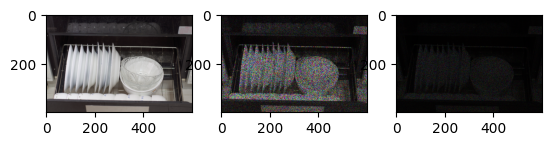

In [6]:
img = cv.imread(InputPath+"/100.png")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
l = img.max()
plt.subplot(1,3,1)
plt.imshow(img)
plt.subplot(1,3,2)
Noise = addNoise(img)
plt.imshow(Noise)
plt.subplot(1,3,3)
hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV) #convert it to hsv
hsv[...,2] = hsv[...,2]*0.2
img1 = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
Noise2 = addNoise(img1)
plt.imshow(Noise2)

# Data Preprocessing

In [7]:
from tqdm import tqdm
HighPath = "/content/drive/MyDrive/LOLdataset/our485/high"

def PreProcessData(ImagePath):
    X_=[]
    y_=[]
    count=0
    for imageName in tqdm(os.listdir(HighPath)):
        count=count+1
        low_img = cv.imread(HighPath + "/" + imageName)
        low_img = cv.cvtColor(low_img, cv.COLOR_BGR2RGB)
        low_img = cv.resize(low_img,(500,500))
        hsv = cv.cvtColor(low_img, cv.COLOR_BGR2HSV) #convert it to hsv
        hsv[...,2] = hsv[...,2]*0.2
        img_1 = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
        Noisey_img = addNoise(img_1)
        X_.append(Noisey_img)
        y_.append(low_img)
    X_ = np.array(X_)
    y_ = np.array(y_)

    return X_,y_

In [8]:
from tqdm import tqdm
import os

HighPath = "/content/drive/MyDrive/LOLdataset/our485/high"

def PreProcessData(ImagePath):
    X_=[]
    y_=[]
    count=0
    for imageName in tqdm(os.listdir(HighPath)):
        count += 1
        image_path = os.path.join(HighPath, imageName)

        # Check if the image path is correct
        if not os.path.isfile(image_path):
            print(f"Error: Image not found at {image_path}")
            continue

        # Read the image
        low_img = cv.imread(image_path)

        # Check if the image is loaded successfully
        if low_img is None:
            print(f"Error: Unable to load the image at {image_path}")
            continue

        low_img = cv.cvtColor(low_img, cv.COLOR_BGR2RGB)
        low_img = cv.resize(low_img, (500, 500))

        # Check if the image is not empty before further processing
        if low_img.size == 0:
            print(f"Error: Empty image at {image_path}")
            continue

        hsv = cv.cvtColor(low_img, cv.COLOR_BGR2HSV)
        hsv[..., 2] = hsv[..., 2] * 0.2
        img_1 = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
        Noisey_img = addNoise(img_1)
        X_.append(Noisey_img)
        y_.append(low_img)

    X_ = np.array(X_)
    y_ = np.array(y_)

    return X_, y_


In [9]:
X_,y_ = PreProcessData(InputPath)

 65%|██████▌   | 318/486 [00:18<00:10, 16.77it/s]

Error: Unable to load the image at /content/drive/MyDrive/LOLdataset/our485/high/.DS_Store


100%|██████████| 486/486 [00:28<00:00, 17.27it/s]


# Model Creation

In [10]:
K.clear_session()
def InstantiateModel(in_):

    model_1 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(in_)
    model_1 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_1)
    model_1 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_1)

    model_2 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(in_)
    model_2 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_2)

    model_2_0 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_2)

    model_add = add([model_1,model_2,model_2_0])

    model_3 = Conv2D(64,(3,3), activation='relu',padding='same',strides=1)(model_add)
    model_3 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_3)
    model_3 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_3)

    model_3_1 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_add)
    model_3_1 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_3_1)

    model_3_2 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_add)

    model_add_2 = add([model_3_1,model_3_2,model_3])

    model_4 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add_2)
    model_4_1 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add)

    model_add_3 = add([model_4_1,model_add_2,model_4])

    model_5 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add_3)
    model_5 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_add_3)

    model_5 = Conv2D(3,(3,3), activation='relu',padding='same',strides=1)(model_5)

    return model_5


In [11]:
Input_Sample = Input(shape=(500, 500,3))
Output_ = InstantiateModel(Input_Sample)
Model_Enhancer = Model(inputs=Input_Sample, outputs=Output_)
Model_Enhancer.compile(optimizer="adam", loss='mean_squared_error')
Model_Enhancer.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 500, 500, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 500, 500, 16)         448       ['input_1[0][0]']             
                                                                                                  
 conv2d_3 (Conv2D)           (None, 500, 500, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 500, 500, 32)         4640      ['conv2d[0][0]']              
                                                                                              

In [12]:
# !pip install --upgrade tensorflow


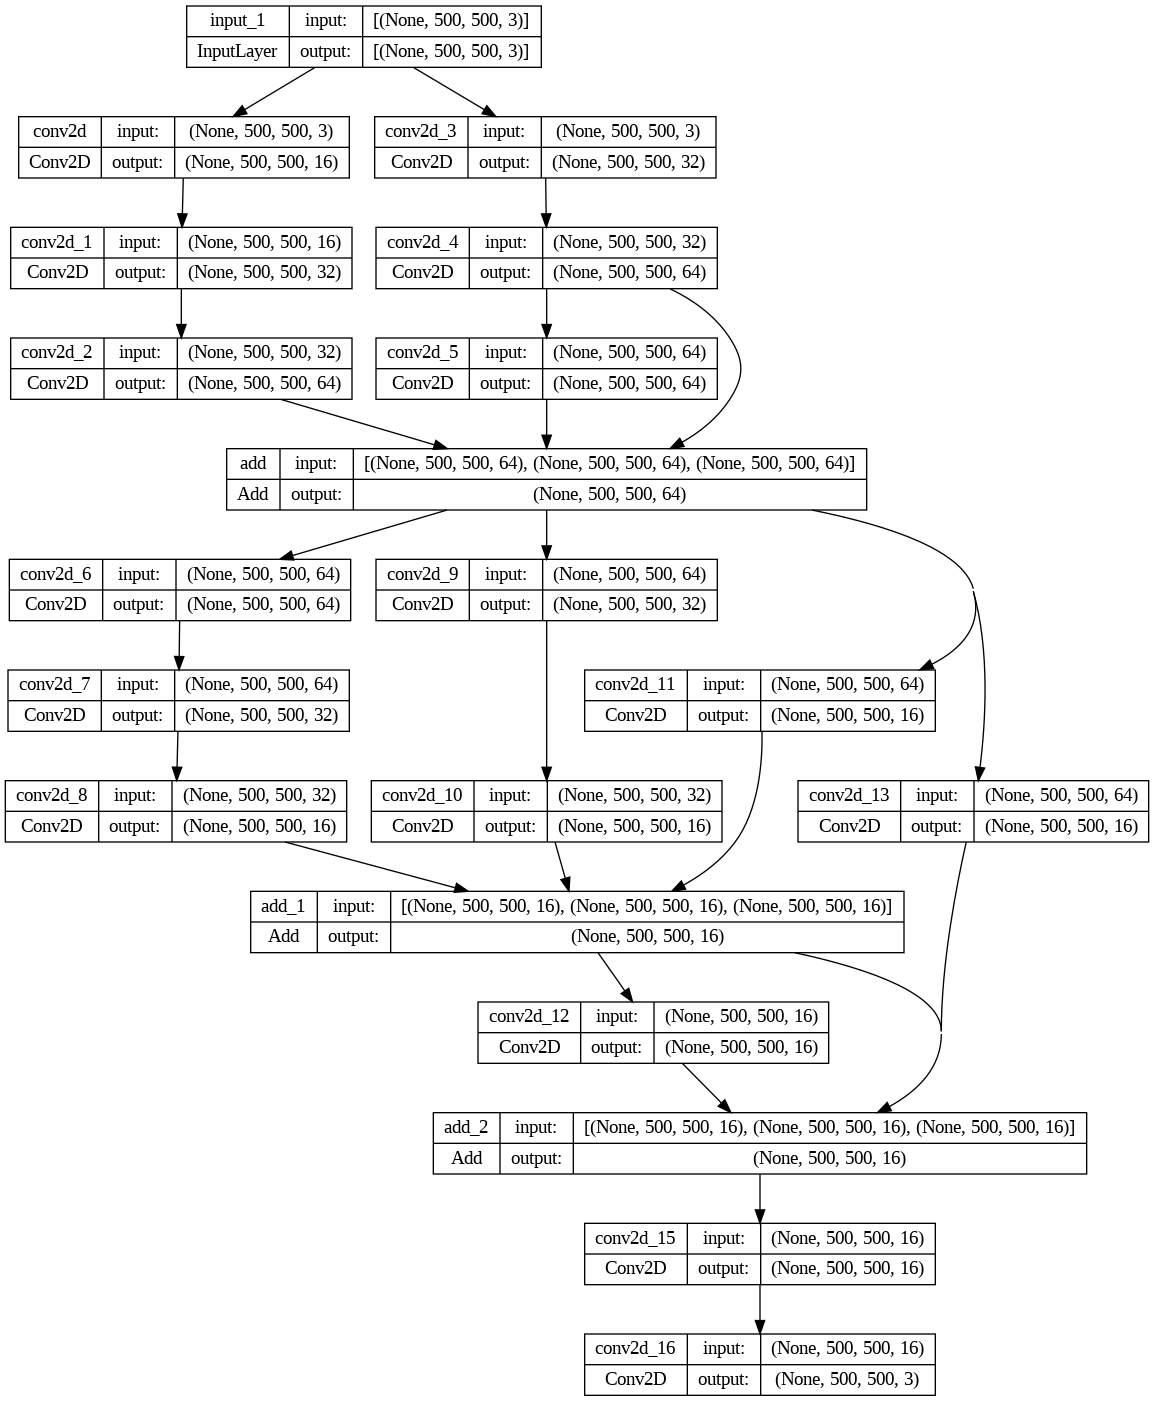

In [14]:
# from tensorflow.keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import plot_model
plot_model(Model_Enhancer,to_file='model_.png',show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image(retina=True, filename='model_.png')

# Training

In [21]:
def GenerateInputs(X,y):
    for i in range(len(X)):
        X_input = X[i].reshape(1,500,500,3)
        y_input = y[i].reshape(1,500,500,3)
        yield (X_input,y_input)
history = Model_Enhancer.fit_generator(GenerateInputs(X_,y_),epochs=53,verbose=1,steps_per_epoch=8,shuffle=True) #epochs * steps_per_epoch <= training dataset images...

Epoch 1/53


<ipython-input-21-3e24564b47bf>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = Model_Enhancer.fit_generator(GenerateInputs(X_,y_),epochs=53,verbose=1,steps_per_epoch=8,shuffle=True) #epochs * steps_per_epoch <= training dataset images...


8/8 [==============================] - 75s 10s/step - loss: 301.7310
Epoch 2/53
8/8 [==============================] - 72s 9s/step - loss: 260.6080
Epoch 3/53
8/8 [==============================] - 74s 9s/step - loss: 201.8584
Epoch 4/53
8/8 [==============================] - 72s 9s/step - loss: 141.4078
Epoch 5/53
8/8 [==============================] - 72s 9s/step - loss: 124.6852
Epoch 6/53
8/8 [==============================] - 75s 9s/step - loss: 263.9768
Epoch 7/53
8/8 [==============================] - 72s 9s/step - loss: 264.6735
Epoch 8/53
8/8 [==============================] - 71s 9s/step - loss: 259.5401
Epoch 9/53
8/8 [==============================] - 74s 9s/step - loss: 348.7596
Epoch 10/53
8/8 [==============================] - 73s 9s/step - loss: 241.0706
Epoch 11/53
8/8 [==============================] - 71s 9s/step - loss: 131.0739
Epoch 12/53
8/8 [==============================] - 74s 9s/step - loss: 100.1609
Epoch 13/53
8/8 [==============================] - 72s 9s/s

In [16]:
TestPath="/content/drive/MyDrive/LOLdataset/our485/high"

In [17]:
def ExtractTestInput(ImagePath):
    img = cv.imread(ImagePath)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_ = cv.resize(img,(500,500))
    hsv = cv.cvtColor(img_, cv.COLOR_BGR2HSV) #convert it to hsv
    hsv[...,2] = hsv[...,2]*0.2
    img1 = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
    Noise = addNoise(img1)
    Noise = Noise.reshape(1,500,500,3)
    return Noise

# Inference

1/1 [==============================] - 2s 2s/step


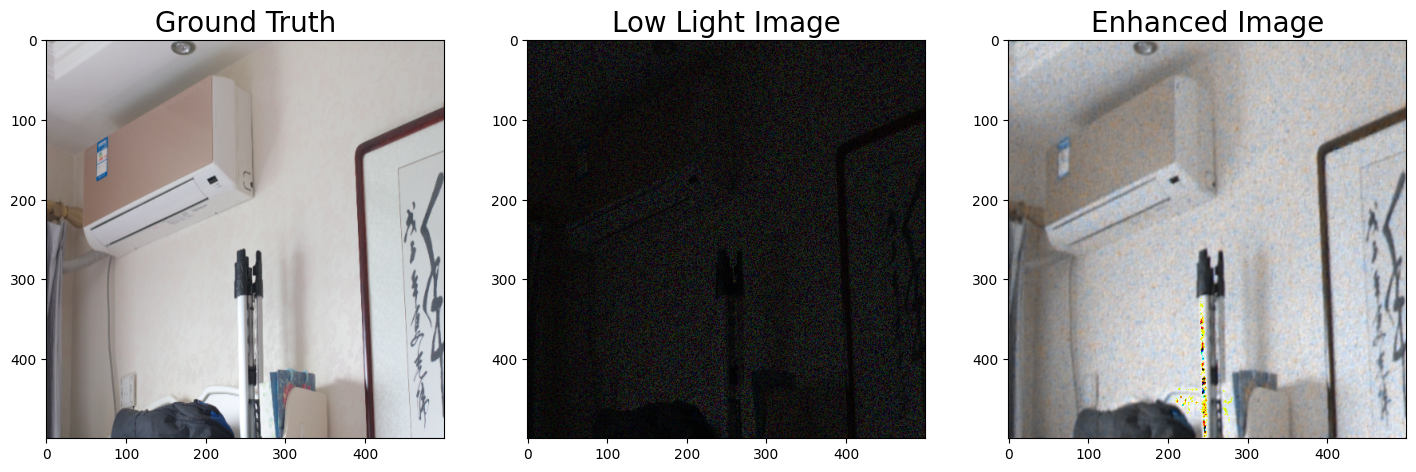

In [27]:
ImagePath=TestPath+"/15.png"

plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
img_1 = cv.imread(ImagePath)
img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
img_1 = cv.resize(img_1, (500, 500))
plt.title("Ground Truth",fontsize=20)
plt.imshow(img_1)

plt.subplot(5,5,1+1)
img_ = ExtractTestInput(ImagePath)
img_ = img_.reshape(500,500,3)
plt.title("Low Light Image",fontsize=20)
plt.imshow(img_)

plt.subplot(5,5,1+2)
image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Enhancer.predict(image_for_test)
Prediction = Prediction.reshape(500,500,3)
img_[:,:,:] = Prediction[:,:,:]
plt.title("Enhanced Image",fontsize=20)
plt.imshow(img_)


In [24]:
# from keras.models import save_model

# # Assuming 'model' is your Keras model
# history.save('history.h5')
# Save the model
Model_Enhancer.save('model_Enhancer.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
import pickle
with open('history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [26]:
from google.colab import files
files.download('history.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>